## Landcover mapping using hyperspectral imagery and deep learning

## Table of Contents
* [Introduction](#1)
* [Hyperion data preparation](#19)
    * [Download hyperion imagery](#2)
    * [Pre-processing of hyperion imagery](#3)
    * [Export training data for deep learning model](#5) 
* [Model training](#7)
    * [Necessary Imports](#6) 
    * [Get training data](#8)
    * [Visualize training data](#9)
    * [Load model architecture](#10)
    * [Train the model](#11)
    * [Visualize classification results in validation set](#12)
    * [Evaluate model performance](#13) 
    * [Save model](#14)
* [Model inference](#15)
* [Results visualization](#18)
* [Limitation](#21)
* [Conclusion](#16)
* [References](#17)

## Introduction<a class="anchor" id="1"></a>

Generally multispectal imageries are preferred for Landuse Landcover (LULC) classification due to their high temporal resolution and high spatial coverage. With the advances in remote sensing technologies, now hyperspectral imageries are also a good option for LULC classification due to their high spectral resolution. The main difference between multispectral and hyperspectral is the number of bands and how narrow the bands are. One of the advantages of hyperspectral sensor over multispectral sensors is its ability to differentiate within the class like tree species, different crop species, etc due to high spectral information content which creates a unique spectral curve for each class.

##### <center> Multispectral imagery<centre>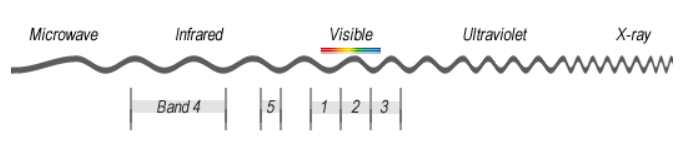

##### <center> Hyperspectral imagery<centre>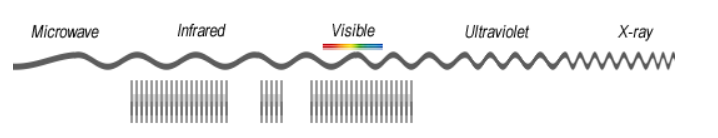

In this notebook, we will use hyperspectral data to train a deep learning model and will see if the model can extract subclasses of two LULC classes: developed areas and forests.
Hyperion imagery is used in the current analysis to classify the types of forests and developed areas. The data can be downloaded from USGS [earth explorer](https://earthexplorer.usgs.gov/). 

## Hyperion data preparation<a class="anchor" id="19"></a>

The [Earth Observing-1 (EO-1) satellite](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-earth-observing-one-eo-1-hyperion?qt-science_center_objects=0#qt-science_center_objects) was launched November 21, 2000 as a one-year technology demonstration/validation mission. After the initial technology mission was completed, NASA and the USGS agreed to the continuation of the EO-1 program as an Extended Mission. The EO-1 Extended Mission is chartered to collect and distribute Hyperion hyperspectral and Advanced Land Imager (ALI) multispectral products according to customer tasking requests.

Hyperion collects 220 unique spectral channels ranging from 0.357 to 2.576 micrometers with a 10-nm bandwidth. The instrument operates in a pushbroom fashion, with a spatial resolution of 30 meters for all bands. The standard scene width is 7.7 kilometers.

### Download hyperion imagery<a class="anchor" id="2"></a>

Login to the earth explorer using the usgs credentials, Select Address/Place option in Geocoding method tab and write the name of area of interest.

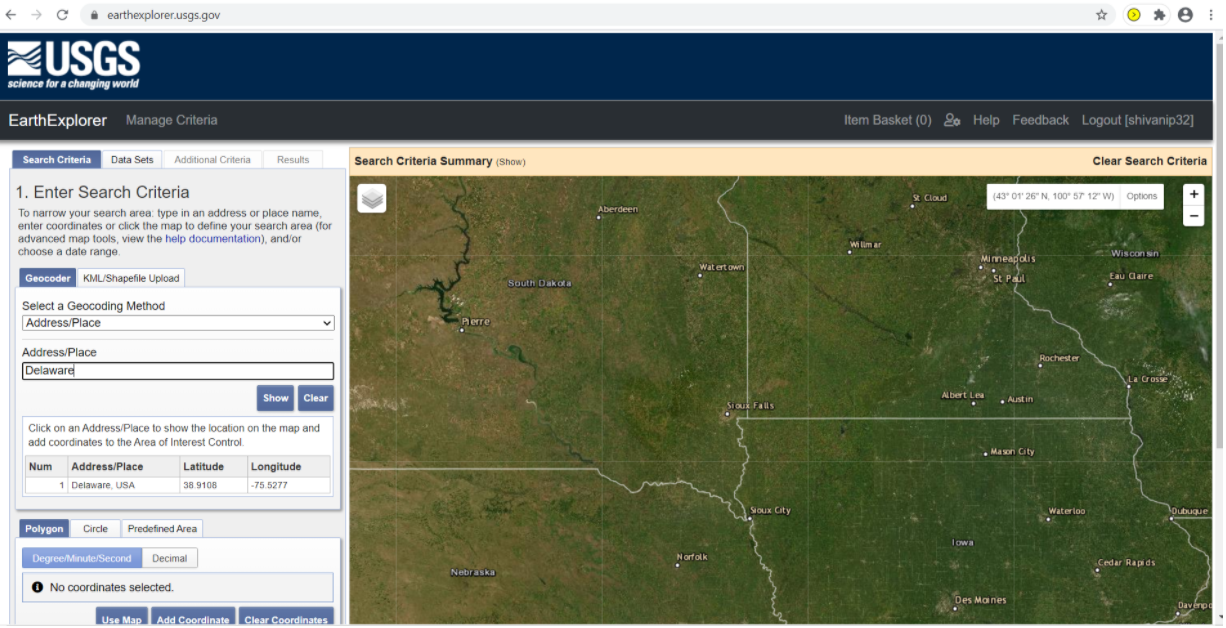

Draw polygon over the area of interest, Change the Cloud Cover Range to 0% - 10%. Click on Results in the bottom left.

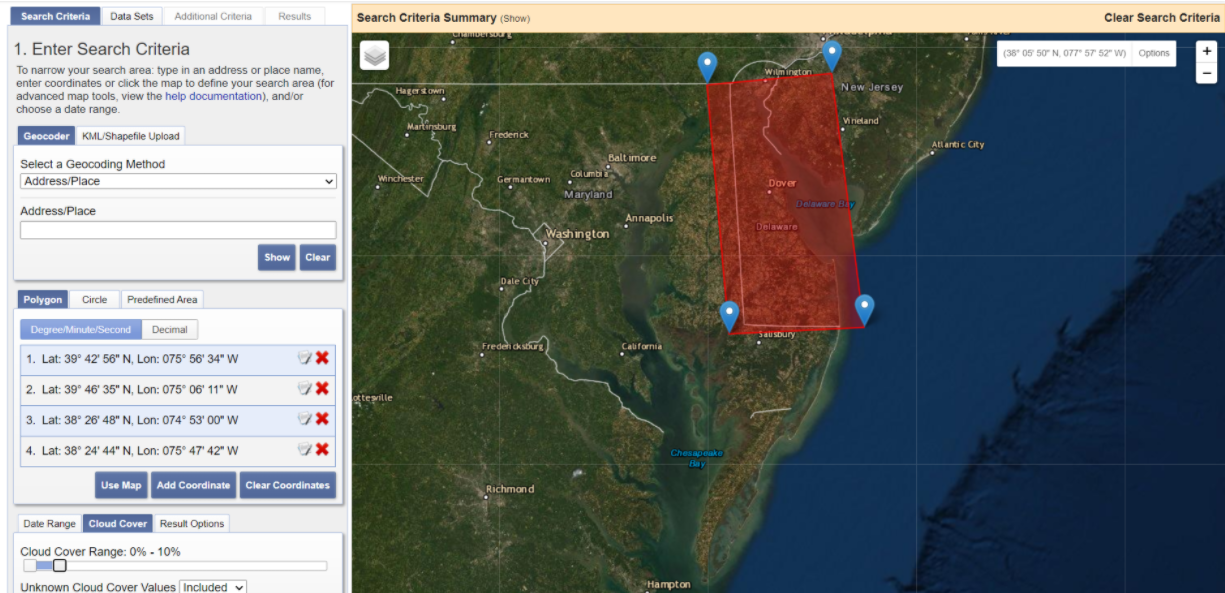

Click on EO-1, select EO-1 Hyperion and click on Results.

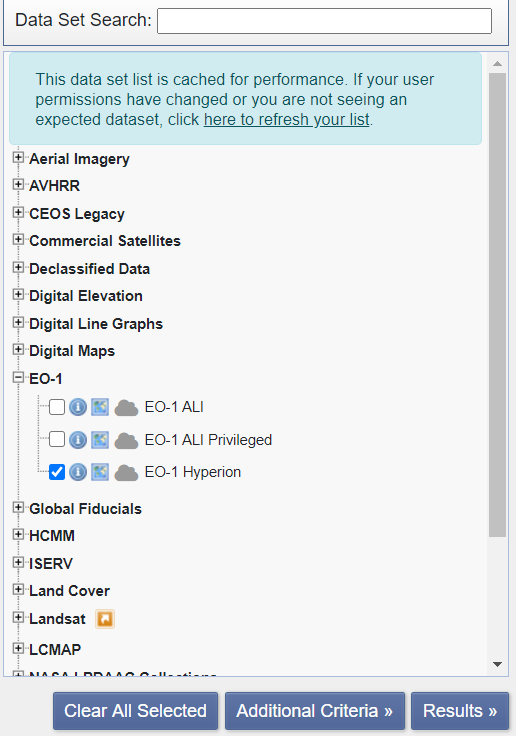

Download data from the product list

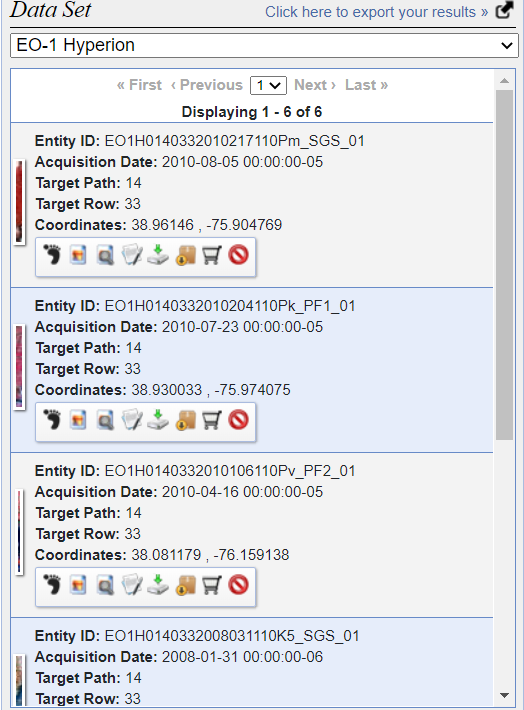

### Pre processing of hyperion imagery<a class="anchor" id="3"></a>

#### Remove bad bands

Not all bands are useful for analysis. Bad bands are primarily water vapor bands consists inforation about atmosphere, that cause spikes in the reflectance curve. List of bad bands of the Hyperion sensor, L1R product are:
1 to 7 - Not illuminated

58 to 78 - Overlap region

120 to 132 - Water vapor absorption band

165 to 182 - Water vapor absorption band

185 to 187 - Identified by Hyperion bad band list

221 to 224 - Water vapor absorption band

225 to 242 - Not illuminated

Bands with vertical stripping - (8-9, 56-57, 78-82, 97-99, 133-134, 152-153, 188, 213-216, 219-220) 

#### Create composite rasters

Two sets of composite rasters were created using [Composite bands function](https://pro.arcgis.com/en/pro-app/help/data/imagery/composite-bands-function.htm). The band range of two raster composites are as follows:

NIR & visible composite - 9 to 55

SWIR composite - 82-96, 100-119, 135-164, 183-184, 189-212, 217-218

Click on Imagery tab -> click on Raster Functions -> Search "Composite Bands" -> Click on browse button and select the bands -> After selecting the bands, click on Create new layer.

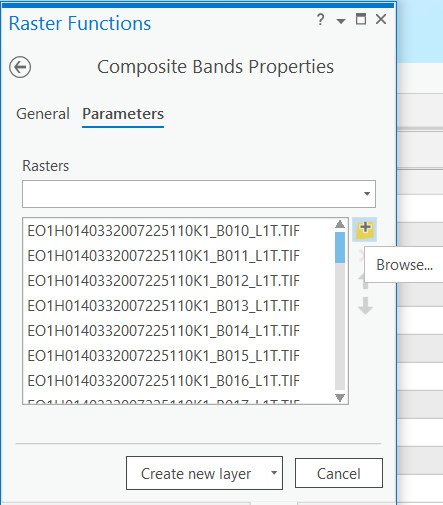

#### Convert DN values to at-sensor radiance

Scale factors will be used to convert the pixel DN value to at-sensor radiance. Scale factor of 40 will be used for VNIR composite raster and 80 for SWIR composite. The rasters will be divided by the scale factor using [Raster Calculator](https://desktop.arcgis.com/en/arcmap/10.3/tools/spatial-analyst-toolbox/raster-calculator.htm) tool in ArcGIS Pro.

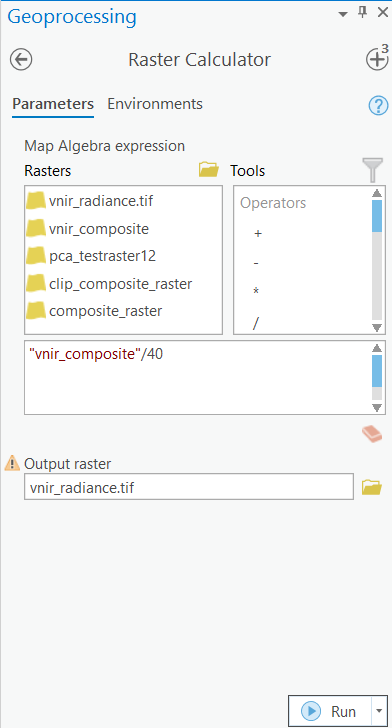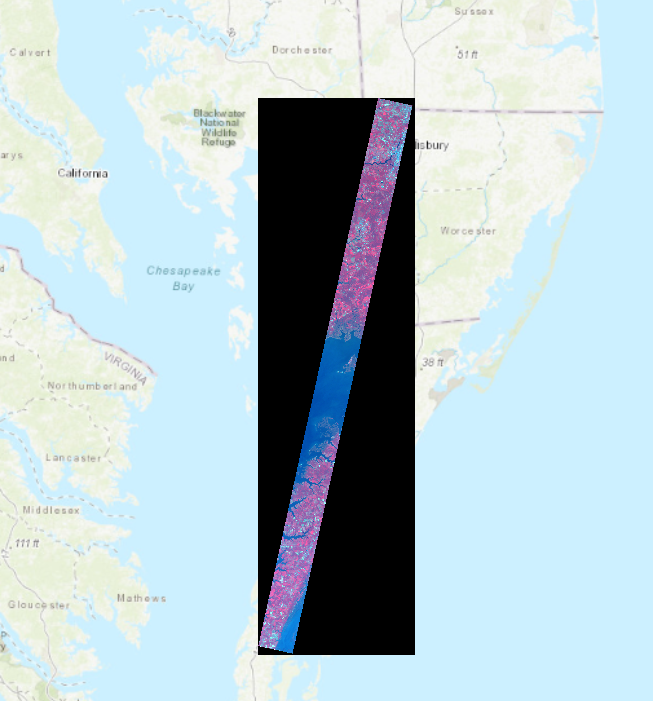

#### Create combined composite raster

Combine both VNIR and SWIR radiance composite rasters using "Composite Band" function.

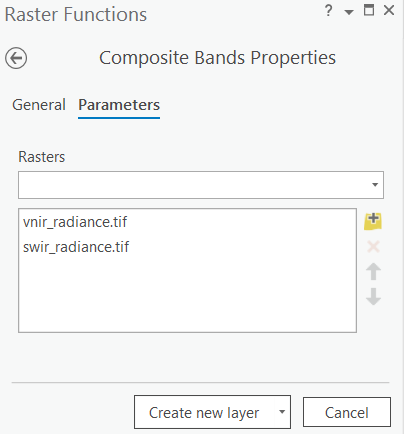

#### Eliminate NoData pixel

##### Create null raster

The output raster has 0 pixel value for NoData which are shown as black pixels. The NoData pixels are eliminated using [Set Null](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/set-null.htm).

Set the parameters as: -

Raster: combined_composite

False raster = 0

Cellsize Type = Max Of

Extent Type = Intersection Of

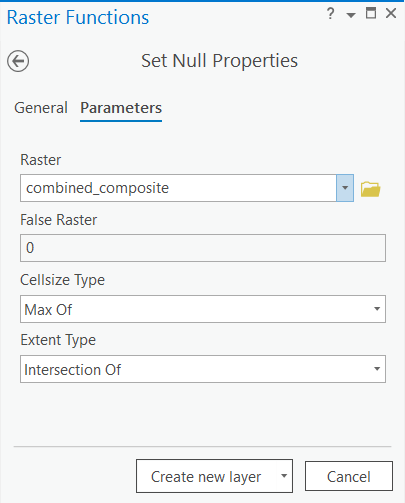

##### Clip

[Clip](https://pro.arcgis.com/en/pro-app/help/data/imagery/clip-function.htm) tool will be used to eliminate NoData from combined composite raster using null raster which was created in previous step.

Parameters:

Raster: combined_composite

Clipping Type: Outside

Clipping Geometry/Raster: null_raster

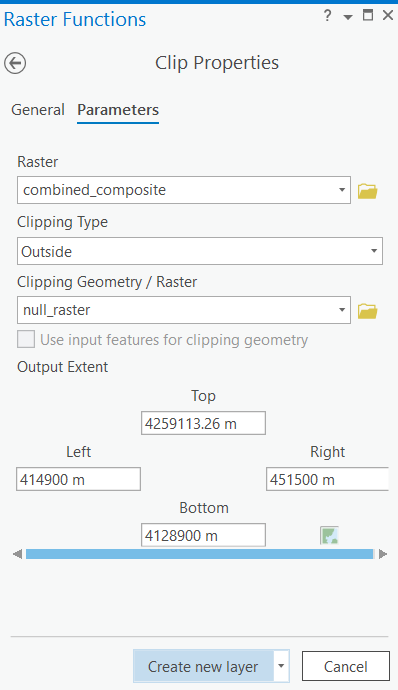

#### Principal Component Analysis

Hyperion has 224 bands to get the bands which have comparatively higher information will be selected using Principal component analysis. [Principal component](https://pro.arcgis.com/en/pro-app/tool-reference/spatial-analyst/principal-components.htm) performs Principal Component Analysis (PCA) on a set of raster bands and generates a single multiband raster as output. The value specified for the number of principal components determines the number of principal component bands in the output multiband raster. The number must not be larger than the total number of raster bands in the input. 

Parameters:

Input raster bands: Clip_combined_composite

Number of Principal components: 12 (12 Principal component were chosen because they covers more than 98% of the total variance)

The output raster will have 12 bands representing 12 Principal components.

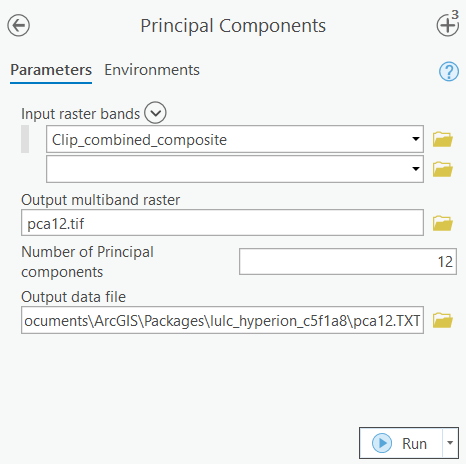

### Export training data for deep learning model<a class="anchor" id="5"></a>

In [1]:
from arcgis.gis import GIS
gis = GIS('home')
ent_gis = GIS('https://pythonapi.playground.esri.com/portal', 'arcgis_python', 'amazing_arcgis_123')

For training data the raster which was created from the hyperion imagery using `Principal Component` tool will be used as `input raster`.

In [2]:
pca_raster = ent_gis.content.search('input_pca_raster_hyperion owner: api_Data_owner', 'Image Layer')[0]
pca_raster

<Item title:"input_pca_raster_hyperion" type:Imagery Layer owner:api_data_owner>

The following feature layer will be used as label for training the model.

<Item title:"label_hyperion" type:Feature Layer Collection owner:api_data_owner>
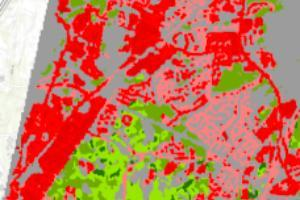

In [3]:
lulc_polygons = ent_gis.content.search('label_hyperion owner: api_Data_owner', 'feature layer')[0]
lulc_polygons

In [4]:
m = gis.map('USA', 4)
m.add_layer(lulc_polygons)
m.legend=True
m

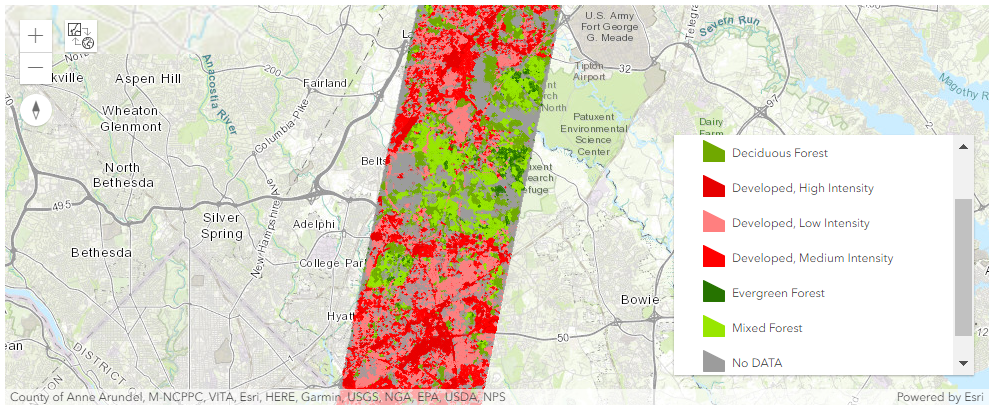

The above layer consists of 7 classes. Developed areas have three sub classes: High, Medium and Low density areas and 3 types of forests: Evergreen, Mixed and Deciduous forest.`No DATA` represents all other LULC classes.

In [5]:
m.zoom_to_layer(lulc_polygons)

A feature layer will be used as a `input mask polygon` while exporting the training data to define the extent of the study area.

<Item title:"mask_polygon_hyperion" type:Feature Layer Collection owner:api_data_owner>
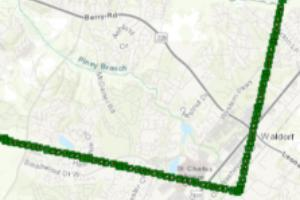

In [8]:
mask_poly = ent_gis.content.search('mask_polygon_hyperion owner: api_Data_owner', 'feature layer')[0]
mask_poly

The [Export training data for deep learning](https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm) is used to prepare training data for training a deep learning model. The tool is available on both `ArcGIS Pro` and `ArcGIS Enterprise`.

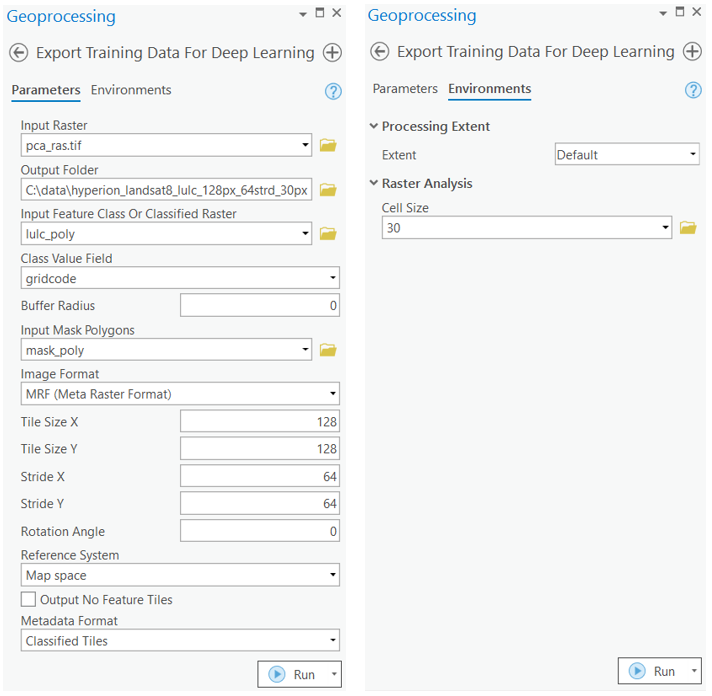

## Model training<a class="anchor" id="7"></a>

This step would be done using jupyter notebook and documentation is available here to install and setup environment.

### Necessary Imports<a class="anchor" id="6"></a>

In [6]:
import os
from pathlib import Path

import arcgis
from arcgis.learn import prepare_data, UnetClassifier

### Get training data<a class="anchor" id="8"></a>

We have already exported the data which can be directly downloaded using the steps below:

<Item title:"landcover_classification_using_hyperspectral_imagery_and_deep_learning" type:Image Collection owner:api_data_owner>
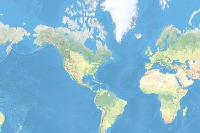

In [7]:
training_data = gis.content.get('0a8ff4ce9f734bb5bb72104aea8526af')
training_data

In [8]:
filepath = training_data.download(file_name=training_data.name)

In [9]:
import zipfile
with zipfile.ZipFile(filepath, 'r') as zip_ref:
    zip_ref.extractall(Path(filepath).parent)

In [10]:
data_path = Path(os.path.join(os.path.splitext(filepath)[0]))

### Visualize training data<a class="anchor" id="9"></a>

`prepare_data` function takes path to training data and creates a fast.ai databunch with specified transformation, batch size, split percentage, etc.

In [11]:
data = prepare_data(data_path,  
                    batch_size=8)

To get a sense of what the training data looks like, use the `show_batch()` method to randomly pick a few training chips and visualize them. The chips are overlaid with masks representing the building footprints in each image chip.

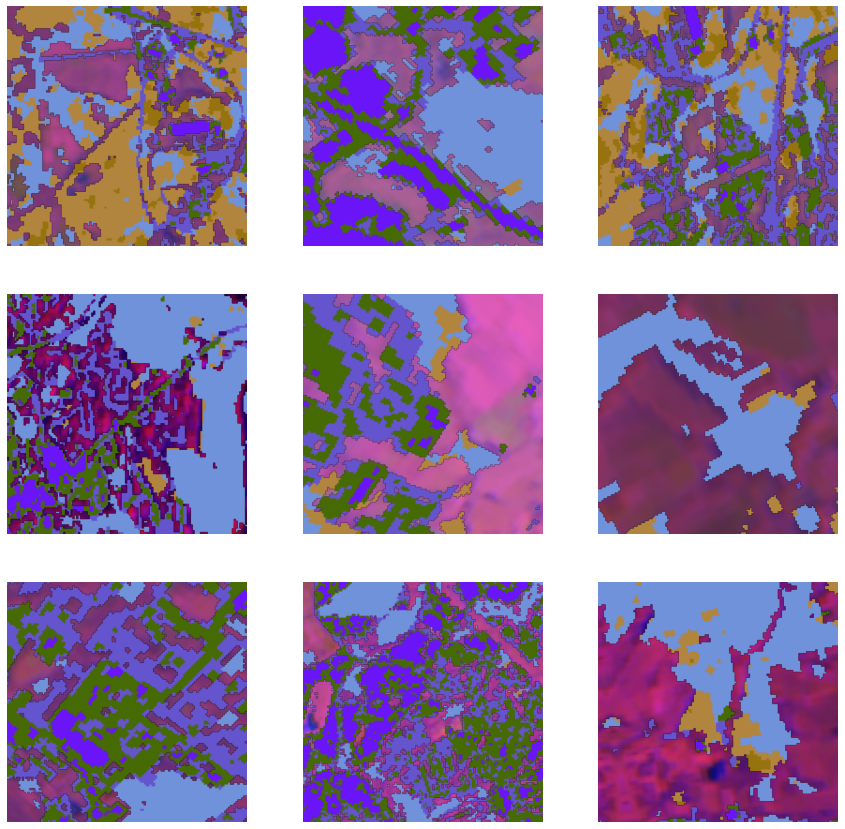

In [12]:
data.show_batch(alpha=1)

### Load model architecture<a class="anchor" id="10"></a>

`arcgis.learn` provides the UnetClassifier model for per pixel classification, which is based on a pretrained convnet, like ResNet that acts as the 'backbone'. More details about UnetClassifier can be found [here](https://developers.arcgis.com/python/api-reference/arcgis.learn.toc.html#unetclassifier).

In [13]:
model = UnetClassifier(data, pointrend=True)

### Train the model<a class="anchor" id="11"></a>


Learning rate is one of the most important hyperparameters in model training. We will use the `lr_find()` method to find an optimum learning rate at which we can train a robust model.

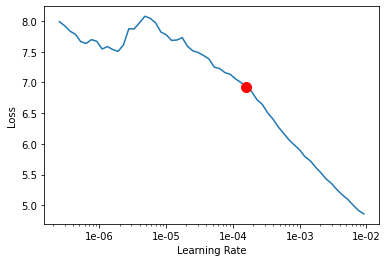

In [14]:
lr = model.lr_find()

We are using the suggested learning rate above to train the model for 2000 epochs.

In [15]:
model.fit(100, lr=lr)

We have further trained the model for 1900 more epochs to improve model performance. For the sake of time, the cell below is commented out.

In [16]:
# model.fit(1900)

### Visualize classification results in validation set<a class="anchor" id="12"></a>

It's a good practice to see results of the model viz-a-viz ground truth. The code below picks random samples and shows us ground truth and model predictions, side by side. This enables us to preview the results of the model within the notebook.

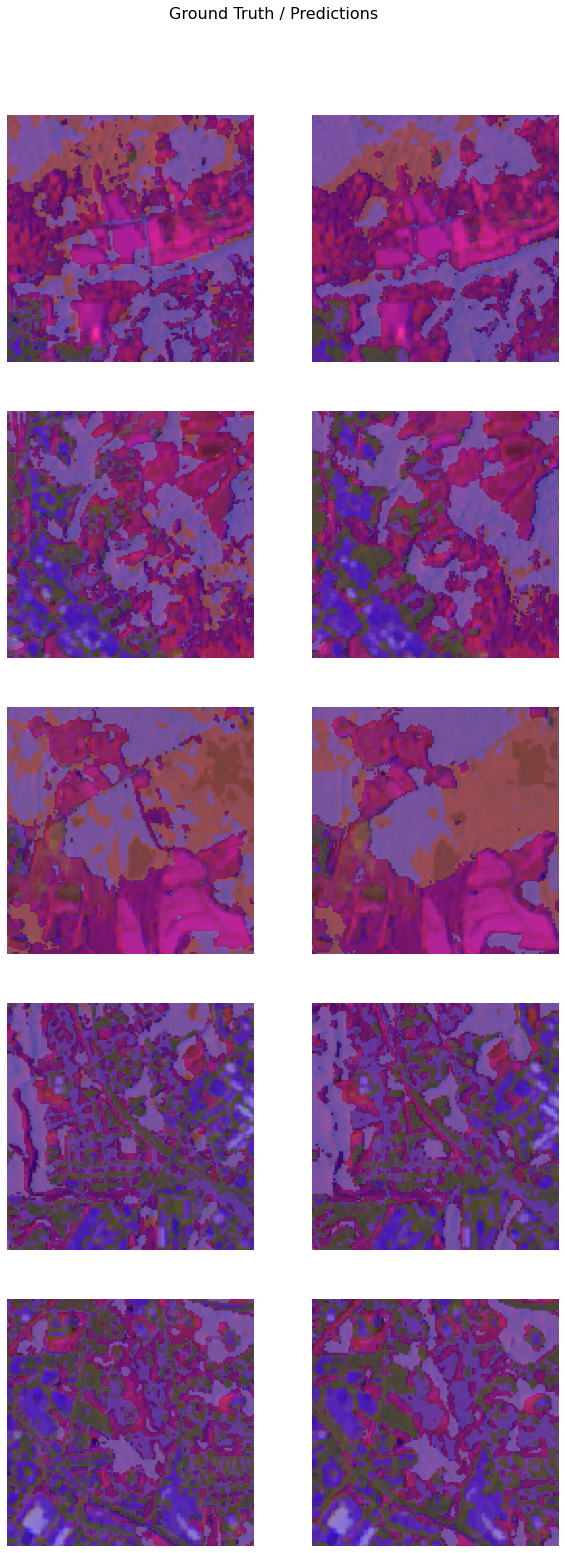

In [17]:
model.show_results()

### Evaluate model performance<a class="anchor" id="13"></a>

As we have 7 classes for this segmentation task, we need to do accuracy assessment for each of those. For that ArcGIS API for Python provides `per_class_metrics` function that will calculate precision and recall and f1 score for each class.

In [18]:
model.per_class_metrics()

NoData  Deciduous Forest  Developed, High Intensity  \
precision  0.689404          0.724823                   0.772128   
recall     0.738998          0.740948                   0.782928   
f1         0.713340          0.732797                   0.777490   

           Developed, Low Intensity  Developed, Medium Intensity  \
precision                  0.637362                     0.637322   
recall                     0.605665                     0.645893   
f1                         0.621109                     0.641579   

           Evergreen Forest  Mixed Forest  
precision          0.730950      0.600000  
recall             0.384463      0.415889  
f1                 0.503891      0.491261

### Save model<a class="anchor" id="14"></a>

We will save the model which we trained as a 'Deep Learning Package' ('.dlpk' format). Deep Learning package is the standard format used to deploy deep learning models on the ArcGIS platform.

We will use the `save()` method to save the trained model. By default, it will be saved to the 'models' sub-folder within our training data folder.

In [19]:
model.save('unet_2000e', publish=True, gis=gis)

Computing model metrics...


WindowsPath('C:/data/2021/hyperspectral/hyperion_l8lulc_128px_64strd_30px_mask_frst_bltp_7classes/models/unet_2000e')

## Model inference<a class="anchor" id="15"></a>

Using ArcGIS Pro, we can inference and get the predictions using the trained model on a test image/area to classify different types of built-up areas and forests in the hyperspectral satellite image.

After we trained the `UnetClassifier` model and saved the weights for classifying image and we could use the [Classify Pixels Using Deep Learning](https://pro.arcgis.com/en/pro-app/latest/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm) tool avialable in both ArcGIS pro and ArcGIS Enterprise for inferencing at scale.

In [20]:
inference_raster = ent_gis.content.search('pca_raster_for_inferencing owner: api_Data_owner', 'Image Layer')[0]
inference_raster

<Item title:"pca_raster_for__inferencing" type:Imagery Layer owner:api_data_owner>

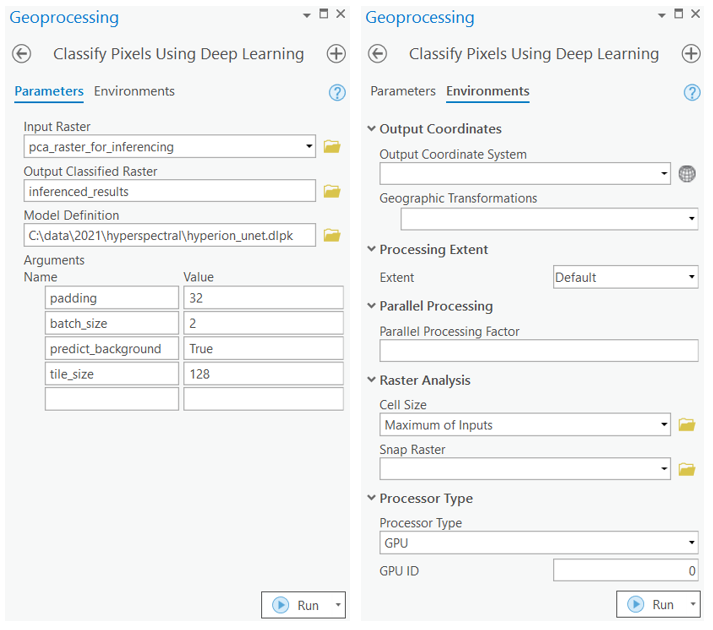

`with arcpy.EnvManager(processorType="GPU"):
out_classified_raster = arcpy.ia.ClassifyPixelsUsingDeepLearning("pca_raster_for_inferencing",  
                                                                r"C:\path\to\model.dlpk", 
                                                                 "padding 32;batch_size 2;predict_background True;
                                                                  tile_size 128", 
                                                                 "PROCESS_AS_MOSAICKED_IMAGE", 
                                                                  None); 
out_classified_raster.save(r"C:\sample\sample.gdb\inferenced_results")`

## Results visualization<a class="anchor" id="18"></a>

The classified output raster is generated using ArcGIS Pro. The output raster is published on the portal for visualization. 

<Item title:"inferenced_results_" type:Map Image Layer owner:api_data_owner>
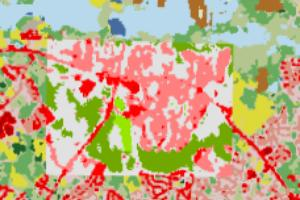

In [21]:
inferenced_results = ent_gis.content.get('29a95588665245359d3787e48fc501cc')
inferenced_results

In [22]:
rgb_imagery = ent_gis.content.get('94d505a8fd084e7f896ba46247b12739')
rgb_imagery

<Item title:"fcc_imagery_l8" type:Imagery Layer owner:api_data_owner>

### Create map widgets
Two map widgets are created showing DSM and Inferenced RGB raster. 

In [23]:
m1 = gis.map()
m1.add_layer(rgb_imagery)
#m1.basemap = 'satellite'
m2 = gis.map()
m2.add_layer(inferenced_results)

### Synchronize web maps

The maps are synchronized with each other using [MapView.sync_navigation](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html#arcgis.widgets.MapView.sync_navigation) functionality. It helps in comparing the inferenced results with the DSM. Detailed description about advanced map widget options can be referred [here](https://developers.arcgis.com/python/guide/advanced-map-widget-usage/).

In [24]:
m1.sync_navigation(m2)

### Set the map layout

In [25]:
from ipywidgets import HBox, VBox, Label, Layout

[Hbox and Vbox](https://developers.arcgis.com/python/api-reference/arcgis.widgets.html?highlight=hbox) were used to set the layout of map widgets.

In [26]:
hbox_layout = Layout()
hbox_layout.justify_content = 'space-around'

hb1=HBox([Label('FCC imagery'),Label('Results')])
hb1.layout=hbox_layout

### Results

The predictions are provided as a map for better visualization.

In [27]:
VBox([hb1,HBox([m1,m2])])

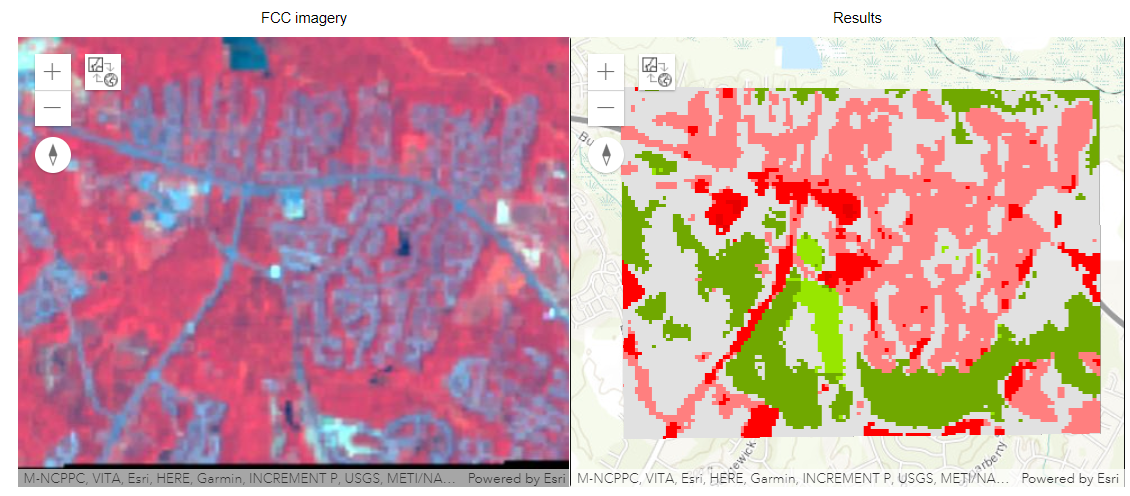

 #### <p style='text-align: right;'> Inferenced results legend </p>
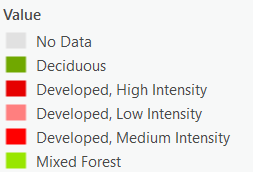

In [28]:
m2.zoom_to_layer(inferenced_results)

In the map widgets, it can be seen that the model is able to differentiate between forests and open spaces (gardens, parks, etc). The different types of developed areas are also accurately classified by the model, The bright blue-gray patches represents Developed areas-high density. Forests are also accurtely classified by the model.

## Limitation<a class="anchor" id="21"></a>

One of the limitation to work with hyperspectral data is it's availability and it is not available for whole world. One tile of hyperion covers small area in comparison to multispectral imageries tiles such as Landsat-8, etc. If a training data is prepared with multiple tiles, a model can be trained and very accurate results can be generated.

## Conclusion<a class="anchor" id="16"></a>

In this notebook, we have covered a lot of ground. Part 1, cover how Hyperion data can be downloaded using USGS Earth Explorer, pre-processing steps of Hyperion and creating a Principal Component raster and how to export training data for deep learning using ArcGIS Pro. Part 2, demonstrates the steps to prepare the input data, train a pixel-based classification model, visualize the results and accuracy metrics. Part-3 shows process of inferencing results on a test raster/area. The same workflow can be used to identify minerals/rocks, plant species, oil spills, etc using hyperspectral imageries and `arcgis.learn` models.

## References<a class="anchor" id="17"></a>

* https://developers.arcgis.com/python/guide/how-unet-works/